In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
import cv2
import os

from glob import glob

import numpy as np

In [33]:
import pickle

In [6]:
calibration_images = glob(os.path.join("camera_cal", "calibration*.jpg"))

In [13]:
object_points = []
image_points = []

obj_point = np.zeros((9*6, 3), np.float32)
obj_point[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

In [24]:
for cal_image in calibration_images:
    img = cv2.imread(cal_image)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    if ret:
        image_points.append(corners)
        object_points.append(obj_point)

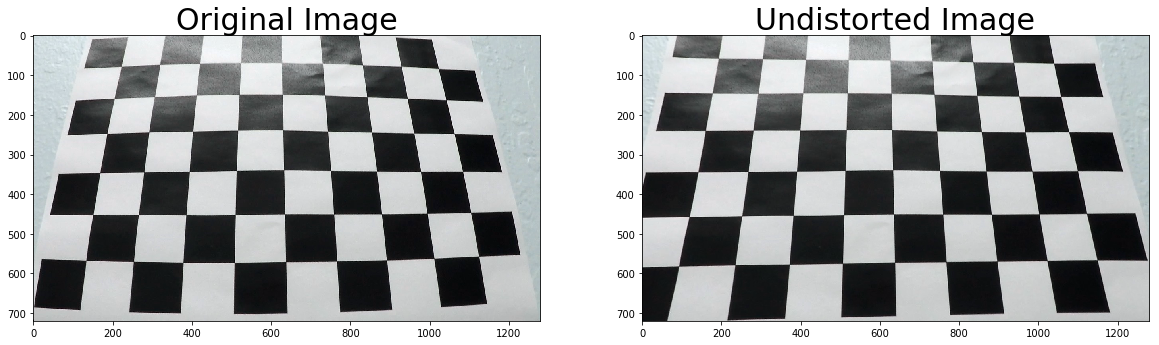

In [31]:
test_image_path = os.path.join("camera_cal", "calibration3.jpg")
test_image = cv2.imread(test_image_path)
img_size = (test_image.shape[1], test_image.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, img_size, None, None)
dst = cv2.undistort(test_image, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [34]:
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ))

In [48]:
img = cv2.imread("test_images/test1.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)
rgb = cv2.cvtColor(undist, cv2.COLOR_BGR2RGB)
hls = cv2.cvtColor(undist, cv2.COLOR_BGR2HLS)
gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)

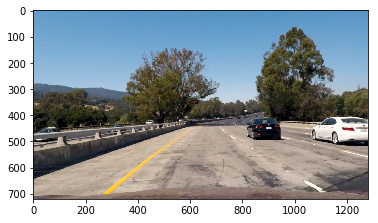

In [49]:
plt.imshow(rgb)

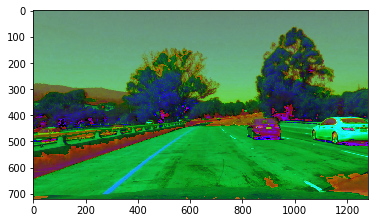

In [50]:
plt.imshow(hls)

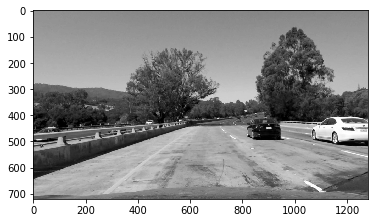

In [51]:
plt.imshow(gray, cmap='gray')

In [52]:
S = hls[:, : ,2]

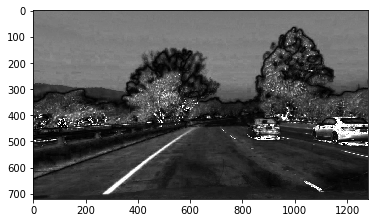

In [53]:
plt.imshow(S, cmap='gray')

In [54]:
sobelx = cv2.Sobel(S, cv2.CV_64F, 1, 0)

In [ ]:
binary = np.zeros_like(sobelx)
binary[() & ()] = 1

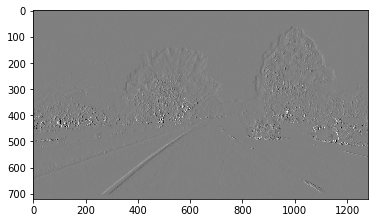

In [56]:
plt.imshow(sobelx, cmap='gray')